In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import xarray as xr

In [2]:
# SEIR, dimensional form

def SEIR(x, t, Ro, taul, taui, taud, d, t_start_qua, t_stop_qua, Rt):
    if (t >= t_start_qua) & (t <= t_stop_qua):
        Roo = Rt
    else:
        Roo = Ro
    S, E, I, If, R, D = x
    xdot = np.array([-Roo/taui*S*I, 
                      Roo/taui*S*I - E/taul, 
                     E/taul - I/taui,
                     d/taui*I - If/taud,
                     I/taui,
                    If/taud])
    return xdot

def solve(N, L, x0, Ro, taul, taui, taud, d, t_start_qua, t_stop_qua, Rt):
    t = np.linspace(0, L, N)
    x = odeint(SEIR, x0, t, args=(Ro, taul, taui, taud, d, t_start_qua, t_stop_qua, Rt))
    return x.T

def solve_xr(N, L, x0, Ro, taul, taui, taud, d, t_start_qua, t_stop_qua, Rt, t0):
    time = pd.to_datetime(pd.date_range(t0,periods=N)) # time axis
    names = ['S','E','I','If','R','D']
    x = solve(N, L, x0, Ro, taul, taui, taud, d, t_start_qua, t_stop_qua, Rt)
    da = xr.merge( [xr.DataArray(x[i],name=names[i],coords=[time],dims=['time']) for i in range(len(names)) ] )
    return da


In [37]:
D_obs = {}

import os
os.system('wget -O obs/FOHM.xlsx https://fohm.maps.arcgis.com/sharing/rest/content/items/b5e7488e117749c19881cce45db13f7e/data')
df=pd.read_excel('obs/FOHM.xlsx',sheet_name='Antal avlidna per dag')[:-1]
D_obs['FOHM'] = xr.DataArray( df['Antal_avlidna'].values,
                 coords=[pd.to_datetime(df['Datum_avliden'].values)],
                 dims=['time'])

df=pd.read_csv('obs/OurWorldInData-daily-covid-deaths.csv')
D_obs['OWID'] = xr.DataArray(df.loc[df['Entity']=='Sweden'].iloc[:,3].values,
                 coords=[pd.to_datetime(df.loc[df['Entity']=='Sweden']['Date'].values)],
                 dims=['time'])

df=pd.read_csv('obs/JohnsHopkins_time_series_covid19_deaths_Sweden.csv')
D_obs['JH'] = xr.DataArray(df.iloc[0].values,
                coords=[pd.to_datetime(pd.date_range(start='2020-01-23',end='2020-04-12'))],
                dims=['time']).diff(dim='time')

os.system('wget -O obs/ECDC.xlsx https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx')
df=pd.read_excel('obs/ECDC.xlsx')
D_obs['ECDC'] = xr.DataArray(df.loc[df['countriesAndTerritories']=='Sweden']['deaths'].values[::-1],
                coords=[pd.to_datetime(df.loc[df['countriesAndTerritories']=='Sweden']['dateRep'].values[::-1],dayfirst=True)],
                dims=['time'])

In [38]:
# Set up parameters

N    = 150   # N.o. timesteps
L    = 150   # length run (days)
Ro   = 3.5   # basic reprod. number
taul = 5.    # duration of latent period (days)
taui = 2.    # duration of infection period (days)
taud = 20.   # time to death from infection (days) 
d    = 0.008  # probability of dying if infected
Rt   = 1.4   # Ro during quarantine
t_start_qua = 35.  # time quarantine starts (days)
t_stop_qua  = L  # time quarantine ends (days)


# Initial conditions
population = 10.e6
t0 = '2020-02-15' # simulation start date
E0 = 10 # initial no. exposed
x0 = np.array([population-E0, E0, 0., 0., 0., 0.])/population

# solve
soln =  solve_xr(N, L, x0, Ro, taul, taui, taud, d, t_start_qua, t_stop_qua, Rt, t0) 


<IPython.core.display.Javascript object>


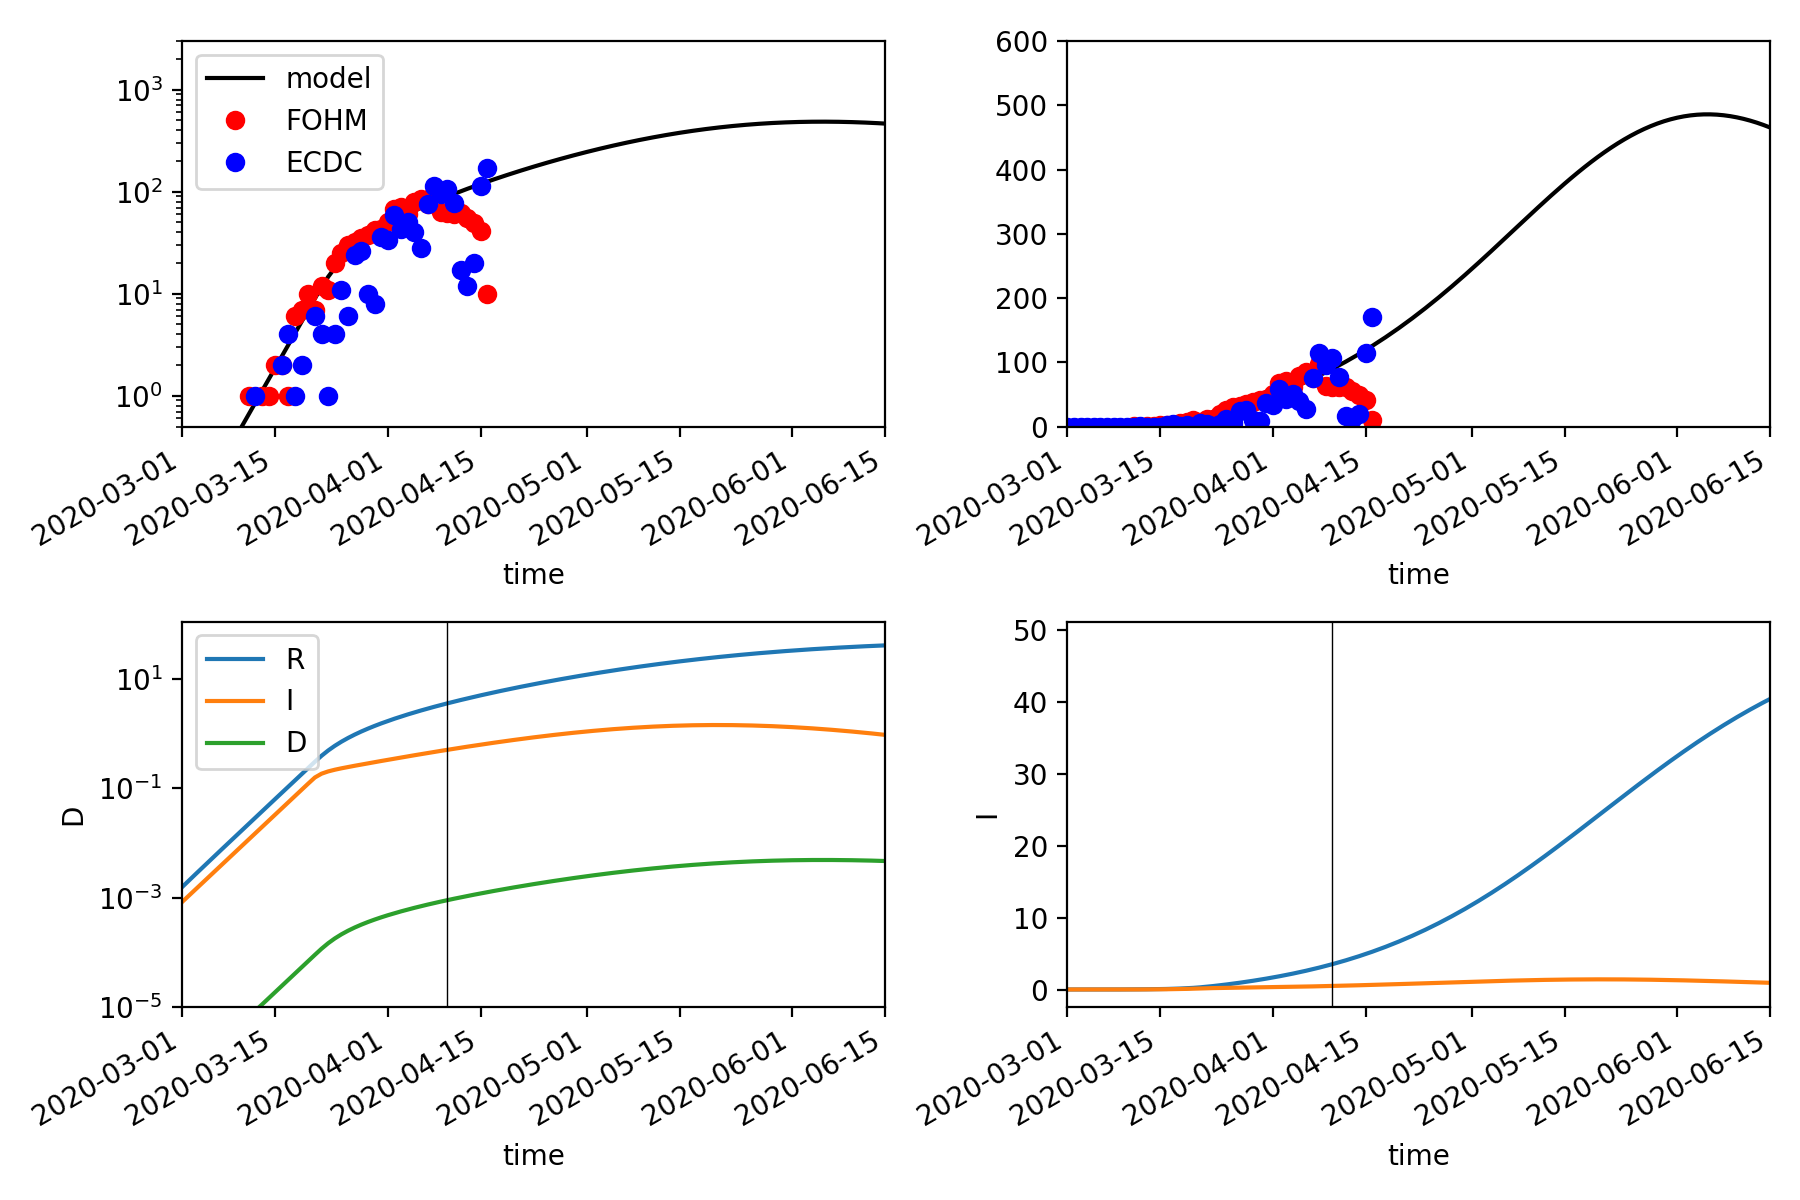

In [39]:
# Plot

%matplotlib notebook

D = soln.D * population

fig, axes = plt.subplots(2, 2, figsize=[9, 6])
axes=axes.flatten()
xlim = ['2020-03-01','2020-06-15']

ax = axes[0]
D.diff(dim='time').plot.line('k',ax=ax)
D_obs['FOHM'].plot.line('ro',ax=ax)
#D_obs['OWID'].plot.line('go',ax=ax)
#D_obs['JH'].plot.line('b+',ax=ax)
D_obs['ECDC'].plot.line('bo',ax=ax)
ax.legend(['model','FOHM','ECDC'])
ax.set_xlim(xlim)
ax.set_ylim(0.5,3000)
ax.set_yscale('log')

ax = axes[1]
D.diff(dim='time').plot.line('k',ax=ax)
D_obs['FOHM'].plot.line('ro',ax=ax)
#D_obs['OWID'].plot.line('go',ax=ax)
#D_obs['JH'].plot.line('b+',ax=ax)
D_obs['ECDC'].plot.line('bo',ax=ax)
ax.set_xlim(xlim)
ax.set_ylim(0,600)
#ax.set_yscale('log')

solnp = soln*100.
ax = axes[2]
solnp['R'].plot.line(ax=ax)
solnp['I'].plot.line(ax=ax)
solnp['D'].diff(dim='time').plot.line(ax=ax)
ax.legend(['R','I','D'])
ax.set_xlim(xlim)
ax.set_ylim(1.e-5,110)
ax.set_yscale('log')
ax.axvline(x='2020-04-10',color='k',lw=0.5)

ax = axes[3]
solnp['R'].plot.line(ax=ax)
solnp['I'].plot.line(ax=ax)
ax.set_xlim(xlim)
#ax.set_ylim(1.e-2,110)
#ax.set_yscale('log')
ax.axvline(x='2020-04-10',color='k',lw=0.5)

plt.tight_layout()
#fig.canvas.header_visible = False

<IPython.core.display.Javascript object>


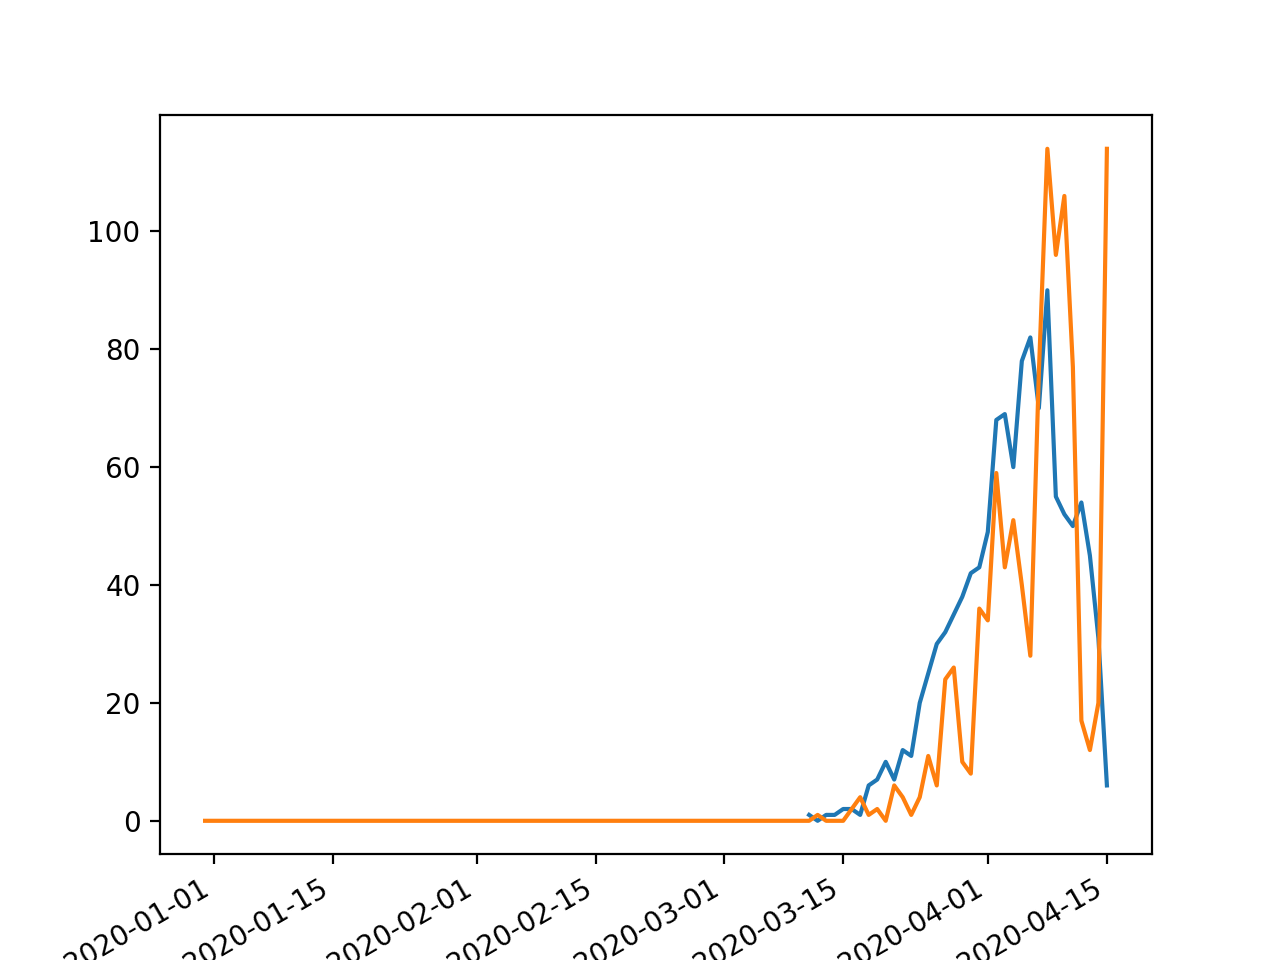

In [33]:
%matplotlib notebook
D_obs['FOHM'].plot()
D_obs['ECDC'].plot()
